In [2]:
# Importing the necessary packahes

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
import shap
import pandas as pd
from sklearn import preprocessing
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import eli5
from eli5.sklearn import PermutationImportance
import json
from sklearn.feature_selection import SelectFromModel
pd.set_option('display.max_columns', 1000)

Defining the evaluation metric

In [2]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [3]:
Defining the evaluation metricdef cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

Loading in the data and splitting it up into the features as specified. One hot encoding and time duration split.

In [4]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [5]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [6]:
# this is the function that convert the raw data into processed features (initial features scraped using external competition code)
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features['installation_session_count'] = sessions_count
            
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1 
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [7]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

Defining the Light gradient boosted and XG boosted model

In [8]:
def run_lgb_regression(reduce_train, reduce_test, usefull_features, n_splits):
    kf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = 42)
    target = 'accuracy_group'
    oof_pred = np.zeros((len(reduce_train), ))
    y_pred = np.zeros((len(reduce_test), ))
    for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, reduce_train[target])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = reduce_train[usefull_features].iloc[tr_ind], reduce_train[usefull_features].iloc[val_ind]
        y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=categoricals)
# hyperparams tuned by trial end error 
        params = {'n_estimators':2000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.9,
                    'num_leaves' : 63,
                    'colsample_bytree' : 0.6,
                    'max_bin' : 27,
                    'reg_alpha' : 0.11,
                    'reg_labda' : 0.01,
                    'min_child_weight' : 0.2,
                    'min_child_samples' : 20,
                    'min_gain_to_split' : 0.02,
                    'min_data_in_bin' : 3,
                    'bin_construct_sample_cnt' : 5000,
                    'cat_12' : 10,
                    'n_thread' : -1,
                    'seed' : 69,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'verbose': 100,
                    'early_stopping_rounds': 100
                    }

        model = lgb.train(params, train_set, num_boost_round = 1000000, early_stopping_rounds = 100, 
                          valid_sets=[train_set, val_set], verbose_eval = 100)
        oof_pred[val_ind] = model.predict(x_val)
        y_pred += model.predict(reduce_test[usefull_features]) / n_splits
    _, loss_score, _ = eval_qwk_lgb_regr(reduce_train[target], oof_pred)
    print('Our oof cohen kappa score is: ', loss_score)

    return y_pred


In [9]:
def run_xgb_regression(reduce_train, reduce_test, usefull_features, n_splits):
    kf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = 69)
    target = 'accuracy_group'
    oof_pred = np.zeros((len(reduce_train), ))
    y_pred = np.zeros((len(reduce_test), ))
    for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, reduce_train[target])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = reduce_train[usefull_features].iloc[tr_ind], reduce_train[usefull_features].iloc[val_ind]
        y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
        xgb_train = xgb.DMatrix(x_train, y_train)
        xgb_eval = xgb.DMatrix(x_val, y_val)

        pars = {
            'colsample_bytree': 0.85,                 
            'learning_rate': 0.01,
            'seed' : 100,
            'subsample': 0.8,
            'num_leaves' : 15,
            'max_depth': 4,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'n_estimators':10000
        }

        model = xgb.train(pars,
                      xgb_train,
                      num_boost_round=5000,
                      evals=[(xgb_train, 'train'), (xgb_eval, 'val')],
                      verbose_eval=100,
                      early_stopping_rounds=100
                     )
        
        val_X=xgb.DMatrix(x_val)
        oof_pred[val_ind] = model.predict(val_X)
        test_X = xgb.DMatrix(reduce_test[usefull_features])
        y_pred += model.predict(test_X) / n_splits
    _, loss_score, _ = eval_qwk_lgb_regr(reduce_train[target], oof_pred)
    print('Our oof cohen kappa score is: ', loss_score)

    return y_pred


Reading the CSVs

In [11]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test) 

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


Checking what features can be engineered and pre-processing them in the next few sections

In [12]:
to_exclude = []
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:
                to_exclude.append(feature)
                #print(feature, train_mean, test_mean)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            #print(feature, train_mean, test_mean)

Permutation Engineering - Picking features out

In [13]:
msk = np.random.rand(len(reduce_train)) < 0.8
train = reduce_train[msk]
val = reduce_train[~msk]
acc = reduce_train['accuracy_group']
inst = reduce_train['installation_id']
t = train.drop(columns=['accuracy_group','installation_id'])
v = val.drop(columns=['accuracy_group','installation_id'])
model = XGBClassifier().fit(t,train['accuracy_group'])
perm = PermutationImportance(model, random_state=1).fit(v,val['accuracy_group'])

Removing all other 'unimportant' features

In [14]:
sel = SelectFromModel(perm, threshold=-5, prefit=True)
feature_idx = sel.get_support()
feature_name = t.columns[feature_idx]
reduce_train = reduce_train[feature_name]
reduce_train['accuracy_group'] = acc
reduce_train['installation_id'] = inst

Removing correlated features

In [15]:
#checking for correlations
corr_matrix = reduce_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
reduce_train.drop(to_drop, axis=1, inplace=True)

Storing only the necesaary features

In [16]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]
features = [x for x in features if x not in to_exclude]
ajusted_test = reduce_test.copy()


Engineered to 238 features from over 900. Can be effectively redued to about 90 without any major drop in performance and with a really good model fit.

In [17]:
print(len(features))

238


Training

Fold 1


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.00924	valid_1's rmse: 1.04792
[200]	training's rmse: 0.925209	valid_1's rmse: 0.998393
[300]	training's rmse: 0.87844	valid_1's rmse: 0.984137
[400]	training's rmse: 0.845139	valid_1's rmse: 0.979455
[500]	training's rmse: 0.817342	valid_1's rmse: 0.977296
[600]	training's rmse: 0.793819	valid_1's rmse: 0.976738
[700]	training's rmse: 0.772547	valid_1's rmse: 0.976605
[800]	training's rmse: 0.753613	valid_1's rmse: 0.976873
Early stopping, best iteration is:
[728]	training's rmse: 0.766982	valid_1's rmse: 0.976502
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.00631	valid_1's rmse: 1.04701
[200]	training's rmse: 0.921706	valid_1's rmse: 1.00311
[300]	training's rmse: 0.875254	valid_1's rmse: 0.993322
[400]	training's rmse: 0.841357	valid_1's rmse: 0.991092
[500]	training's rmse: 0.814347	valid_1's rmse: 0.990997
Early stopping, best iteration is:
[441]	t

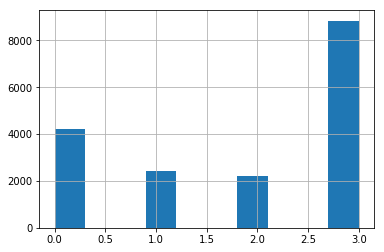

In [18]:
y_lgb_pred = run_lgb_regression(reduce_train, ajusted_test, features, 5)

Fold 1


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.85814	val-rmse:1.85795
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.19703	val-rmse:1.2062
[200]	train-rmse:1.04536	val-rmse:1.06437
[300]	train-rmse:1.00149	val-rmse:1.02983
[400]	train-rmse:0.979739	val-rmse:1.01605
[500]	train-rmse:0.965052	val-rmse:1.00862
[600]	train-rmse:0.953979	val-rmse:1.00434
[700]	train-rmse:0.944927	val-rmse:1.00166
[800]	train-rmse:0.937224	val-rmse:0.999904
[900]	train-rmse:0.930106	val-rmse:0.998212
[1000]	train-rmse:0.923572	val-rmse:0.997363
[1100]	train-rmse:0.917228	val-rmse:0.99671
[1200]	train-rmse:0.91123	val-rmse:0.99591
[1300]	train-rmse:0.905749	val-rmse:0.995502
[1400]	train-rmse:0.900156	val-rmse:0.995078
[1500]	train-rmse:0.895109	val-rmse:0.994793
[1600]	train-rmse:0.889994	val-rmse:0.994443
[1700]	train-rmse:0.88493	val-rmse:0.994027
[1800]	train-rmse:0.880072	val-rmse:0.993801
[1900]	train-rmse:0.875162	val-r

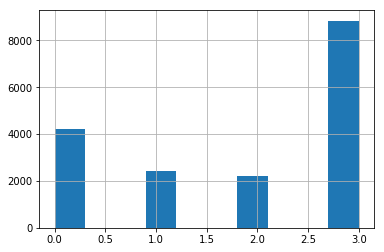

In [19]:
y_xgb_pred = run_xgb_regression(reduce_train, ajusted_test, features, 5)

Ensembling the two models with their respective weights. (Tuned by trial and error)

In [20]:
lgb_weight = 0.6
final_pred = y_lgb_pred * lgb_weight + y_xgb_pred * (1 - lgb_weight)
print(final_pred.shape, y_lgb_pred.shape, y_xgb_pred.shape)

(1000,) (1000,) (1000,)


{0: 1.4896280244829119, 1: 1.9382802501734349, 2: 2.1525047831399275}


3    0.500
0    0.239
1    0.136
2    0.125
Name: accuracy_group, dtype: float64

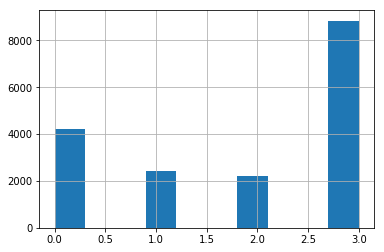

In [21]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)